## Importation des packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import logging
import re
import string
import contractions
import shutil
import category_encoders
from category_encoders import TargetEncoder

from glob import glob

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import nltk
from tqdm import tqdm

from PIL import Image as Image_PIL
from PIL import ImageOps

from sklearn import cluster, metrics
from sklearn.metrics import classification_report, confusion_matrix, adjusted_rand_score, precision_score, f1_score, recall_score, accuracy_score, auc, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from umap import UMAP
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import manifold, decomposition
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow_hub as hub
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import load_img, to_categorical
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications import resnet, ResNet50, vgg16, VGG19, vgg19, Xception, xception, InceptionV3, inception_v3
from keras.applications.xception import preprocess_input
from plot_keras_history import show_history, plot_history
from sentence_transformers import SentenceTransformer

import gensim
import os
from os import listdir
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

C:\Users\JayCo\anaconda3\envs\EnvP6\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\JayCo\anaconda3\envs\EnvP6\lib\site-packages\transformers\generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
C:\Users\JayCo\anaconda3\envs\EnvP6\lib\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


## Fonctions

In [2]:
# Fonction de détermination du nombre de dimensions du SVD
def select_n_components(features, goal_var: float) -> int:

    # Création et fit du modèle
    tsvd = TruncatedSVD(n_components=features.shape[1]-1)
    tsvd.fit(features)
    tsvd_var_ratios = tsvd.explained_variance_ratio_

    # Initialisation
    total_variance = 0.0
    n_components = 0

    # boucle pour avoir le nombre de composante expliquant goal_var variance :
    for explained_variance in tsvd_var_ratios:

        # somme de la variance expliquée par itération
        total_variance += explained_variance

        # Nb composantes +1 par itération
        n_components += 1

        # Si la variance totale > objectifs
        if total_variance >= goal_var:
            # Arrêt de la boucle
            break

    # Return the number of components
    return n_components


# Fonction de réduction de dimension (SVD, T-SNE et UMAP)
def reduction_fct(features, reduc='SVD'):

    if reduc == 'SVD':
        n_comp = select_n_components(features, goal_var=0.99)
        print(f"Number of dimensions before TSVD: {features.shape[1]}")
        print(
            f"Number of dimensions after TSVD (99% var. explained): {n_comp}")
        modelSVD = TruncatedSVD(n_components=n_comp, random_state=42)
        reduc_X = modelSVD.fit_transform(features)
        return reduc_X

    elif reduc == 'TSNE':
        tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                    init='random', learning_rate=200, random_state=42)
        reduc_X = tsne.fit_transform(features)
        return reduc_X

    elif reduc == 'UMAP':
        modelUMAP = UMAP(n_neighbors=200,
                         min_dist=1,
                         n_components=2,
                         random_state=42)
        reduc_X = modelUMAP.fit_transform(features)
        return reduc_X

    else:
        print("please select 'SVD' (PCA equivalent for sparse data),'TSNE' or 'UMAP'")


# Fonction de clusterisation via KMeans
def kmeans_fct(features, y_categ):
    """ Fonction permettant de réaliser un kmeans et de calculer l'ARI entre les vrais labels et les labels prédits"""
    # Détermination des clusters à partir des données après Tsne
    num_labels = len(set(y_categ))
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(features)
    ARI = np.round(adjusted_rand_score(y_categ, cls.labels_), 4)
    print("ARI : ", ARI)

    return ARI, cls.labels_


#Fonction de représentation graphique en deux dimensions (après réduction)
def reduc_visu_fct(reduc_X, target, labels):
    """visualisation des axes réduits (2 premiers) selon les vraies catégories et selon les clusters"""
    # Encodage des targets pour la couleur des clusters
    LE = LabelEncoder()
    y_categ = LE.fit_transform(target)
    categ = list(set(target))

    # représentation graphique
    fig = plt.figure(figsize=(20, 8))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=y_categ, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[
              0], labels=categ, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(
        labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')

    plt.show()

In [3]:
# Fonction de préparation des images
# redimensionnement
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(df['img'])) :
        img = (load_img(
            df['img'][image_num],
            target_size=(299, 299)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

In [4]:
# Fonction de génération des prédictions pour la matrice de confusion
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [5]:
def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='img', y_col='main_cat',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=bs, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [6]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [7]:
# Fonction de création du modèle Xception (sans data augmentation)
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = Xception(include_top = False, weights = "imagenet", input_shape = (299, 299, 3), pooling='avg')

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [8]:
# Fonction de création du modèle Xception (avec data augmentation)
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", 
        input_shape=(299, 299, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = Xception(include_top = False, weights = "imagenet", input_shape = (299, 299, 3), pooling='avg')
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

## Ouverture du Dataset cleané

In [9]:
# Définition des chemins sources
path = './Flipkart/'
path_img = './Images/'
path_img_test = './Images_test/'

data_path = glob(path_img+'*/*.jp*')
data_test_path = glob(path_img_test+'*/*.jp*')

# Ouverture et aperçu du fichier
df = pd.read_csv(path+'clean_data.csv')
df.head()

,Unnamed: 0,uniq_id,crawl_timestamp,product_name,image,description,product_specifications,main_cat,sub_cat_1,sub_cat_2,clean_description,length
0,0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,Curtains,"['key', 'featur', 'eleg', 'polyest', 'multicol...",162
1,1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,Baby Bath Towels,"['specif', 'sathiya', 'cotton', 'bath', 'towel...",64
2,2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin,Baby Bath Towels,"['key', 'featur', 'eurospa', 'cotton', 'terri'...",156
3,3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen,Bedsheets,"['key', 'featur', 'santosh', 'royal', 'fashion...",118
4,4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen,Bedsheets,"['key', 'featur', 'jaipur', 'print', 'cotton',...",157


# Text features (TF-IDF)

In [10]:
# Exemple de description cleanée

df['clean_description'].iloc[0]

"['key', 'featur', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'r', 'this', 'curtain', 'enhanc', 'look', 'interior', 'this', 'curtain', 'made', 'high', 'qualiti', 'polyest', 'fabric', 'it', 'featur', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'it', 'make', 'room', 'environ', 'romant', 'love', 'this', 'curtain', 'ant', 'wrinkl', 'anti', 'shrinkag', 'eleg', 'appar', 'give', 'home', 'bright', 'modernist', 'appeal', 'design', 'the', 'surreal', 'attent', 'sure', 'steal', 'heart', 'these', 'contemporari', 'eyelet', 'valanc', 'curtain', 'slide', 'smooth', 'draw', 'apart', 'first', 'thing', 'morn', 'welcom', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morn', 'whole', 'world', 'draw', 'close', 'even', 'creat', 'special', 'moment', 'joyous', 'beauti', 'given', 'sooth', 'print', 'bring', 'home', 'eleg', 'curtain', 'soft', 'filter', '

In [11]:
# Modèle TF-IDF

ctf = TfidfVectorizer(max_df=0.95, min_df=1)
ctf_fit = ctf.fit(df['clean_description'])
ctf_transform = ctf.transform(df['clean_description']) 

ARI :  0.4497


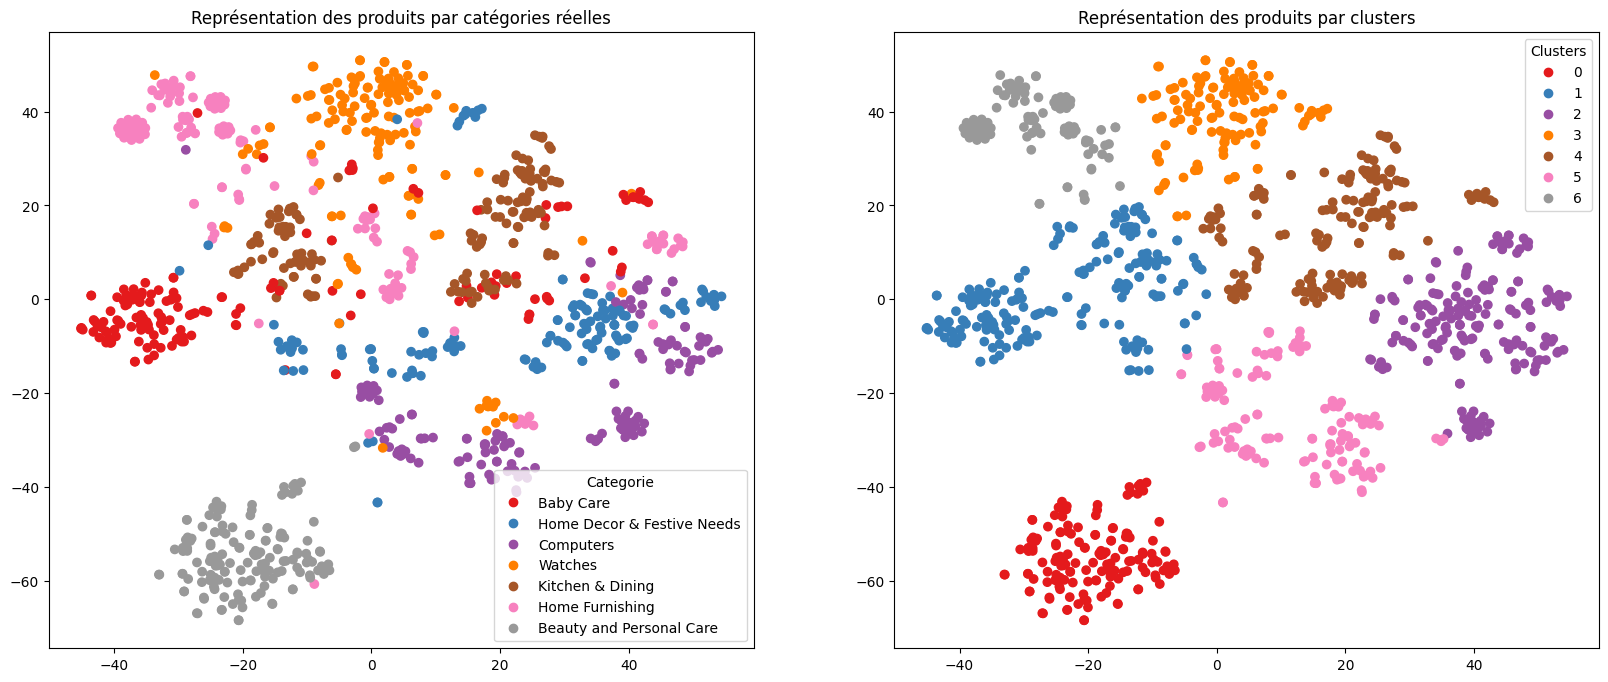

In [12]:
# Application du modèle

X_reduc_TFIDF = reduction_fct(ctf_transform, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc_TFIDF, df['main_cat'])
reduc_visu_fct(X_reduc_TFIDF, df['main_cat'], labels)

# Images features

In [13]:
# Modèle Xception

list_photos = [file for file in listdir(path_img)]
df['img'] = df['image'].apply(lambda x: path_img+str(x))

xception_model = Xception(
    include_top = False,
    weights = "imagenet",
    input_shape = (299, 299, 3),
    pooling='avg'
)

X = []

for image_num in range(len(list_photos)):
    img = load_img(df['img'][image_num], target_size = (299, 299))
    img = ImageOps.equalize(img, mask = None)
    img = np.array(img)
    reshaped_img = img.reshape(299, 299, 3)
    imgx = xception.preprocess_input(reshaped_img)
    X.append(imgx)

X = np.array(X)

Xcep_features = xception_model.predict(X, use_multiprocessing=True)

C:\Users\JayCo\anaconda3\envs\EnvP6\lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


33/33 [==============================] - 54s 2s/step


ARI :  0.5537


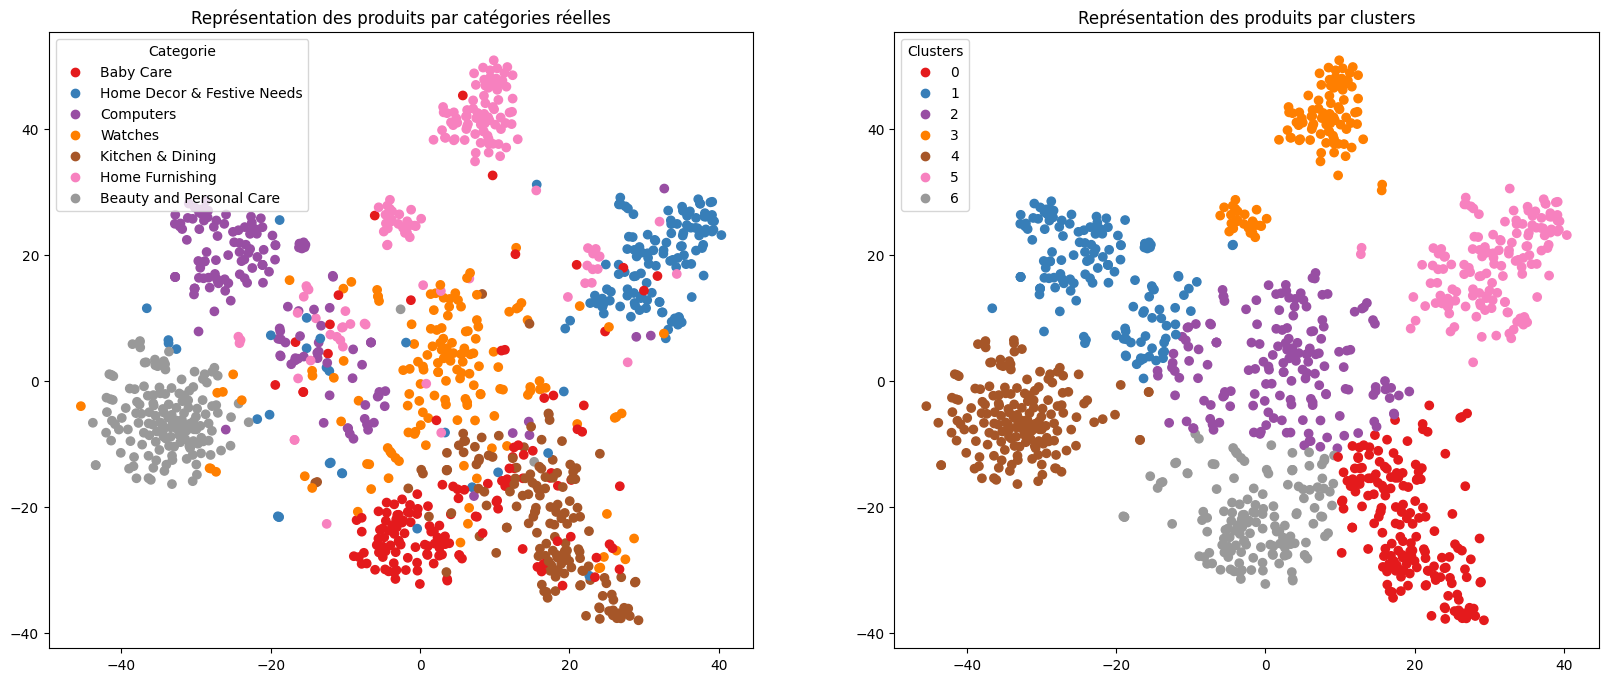

In [14]:
# Application du modèle

X_reduc_Xcep = reduction_fct(Xcep_features, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc_Xcep, df['main_cat'])
reduc_visu_fct(X_reduc_Xcep, df['main_cat'], labels)

# Classification supervisée

Pour la modélisation, nous utiliserons le modèle le plus pertinent selon le Notebook 2, à savoir Xception (meilleur score ARI en classification non supervisée).  
  
Les différentes méthodes seront les suivantes :
  
1. RandomForest (approche simple)  
2. Approche par préparation initiale des images  
3. ImageDataGenerator (avec data augmentation)  
4. Image_dataset_from_directory (avec data augmentation)

### Préparation du dataset

In [15]:
# Paramètres (batch_size, random_state en encodeur)
encoder = LabelEncoder()
bs = 32
rs = 42

In [16]:
# Suppression des features superflues
df.drop(['Unnamed: 0', 
         'uniq_id', 
         'crawl_timestamp', 
         'product_name', 
         'product_specifications', 
         'sub_cat_1', 
         'sub_cat_2'], axis = 1, inplace = True)

# Listing des catégories réelles 
list_labels = ['Baby Care', 
               'Beauty and Personal Care', 
               'Computers', 
               'Home Decor & Festive Needs', 
               'Home Furnishing', 
               'Kitchen & Dining',
               'Watches']

# Création feature : chemin + nom de l'image
df['img'] = df['image'].apply(lambda x: path_img+str(x))

# Encodage des catégories réelles (LabelEncoder)
df['label'] = encoder.fit_transform(df['main_cat'])

# Copie du fichier, et aperçu
df_test = df.copy()
df_test.head()

,image,description,main_cat,clean_description,length,img,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,"['key', 'featur', 'eleg', 'polyest', 'multicol...",162,./Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,"['specif', 'sathiya', 'cotton', 'bath', 'towel...",64,./Images/7b72c92c2f6c40268628ec5f14c6d590.jpg,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,"['key', 'featur', 'eurospa', 'cotton', 'terri'...",156,./Images/64d5d4a258243731dc7bbb1eef49ad74.jpg,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,"['key', 'featur', 'santosh', 'royal', 'fashion...",118,./Images/d4684dcdc759dd9cdf41504698d737d8.jpg,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,"['key', 'featur', 'jaipur', 'print', 'cotton',...",157,./Images/6325b6870c54cd47be6ebfbffa620ec7.jpg,4


## Approche simple avec RandomForest

In [18]:
X = Xcep_features
y = df['main_cat']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = rs)


model_RF = RandomForestClassifier(random_state = 0)

start_rf = time.time()
history1 = model_RF.fit(X_train, y_train)
end_rf = time.time()
time_rf = round(end_rf - start_rf, 2)

predictions = history1.predict(X_test)

cm = metrics.confusion_matrix(y_test, predictions)

conf_mat = metrics.confusion_matrix(y_test, predictions)

ARI = np.round(metrics.adjusted_rand_score(y_test, predictions),4)
print("Temps d'entrainement : {}s".format(time_rf))
print("ARI : ", ARI)
print()
print(conf_mat)
print()
print(metrics.classification_report(y_test, predictions))

Temps d'entrainement : 1.55s
ARI :  0.7137

[[18  1  1  4  3  0  0]
 [ 1 18  0  1  1  0  0]
 [ 0  0 37  1  0  0  0]
 [ 1  1  2 25  0  0  1]
 [ 2  0  1  1 31  0  0]
 [ 0  1  3  2  0 20  0]
 [ 0  0  1  0  0  0 32]]

                            precision    recall  f1-score   support

                 Baby Care       0.82      0.67      0.73        27
  Beauty and Personal Care       0.86      0.86      0.86        21
                 Computers       0.82      0.97      0.89        38
Home Decor & Festive Needs       0.74      0.83      0.78        30
           Home Furnishing       0.89      0.89      0.89        35
          Kitchen & Dining       1.00      0.77      0.87        26
                   Watches       0.97      0.97      0.97        33

                  accuracy                           0.86       210
                 macro avg       0.87      0.85      0.86       210
              weighted avg       0.87      0.86      0.86       210



<Axes: >

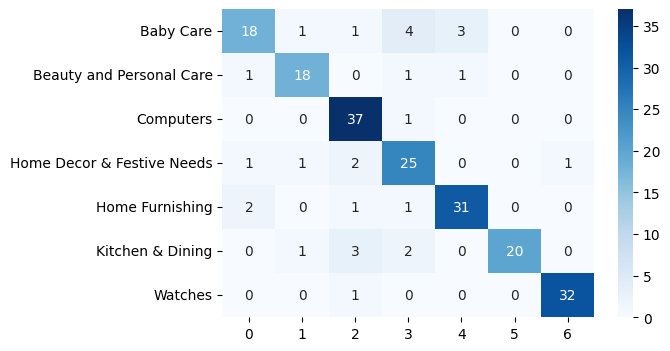

In [19]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Approche 1 : préparation initiale des images

In [20]:
images_np = image_prep_fct(df)
print(images_np.shape)
images_np_test = image_prep_fct(df_test)
print(images_np_test.shape)

C:\Users\JayCo\anaconda3\envs\EnvP6\lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(1050, 299, 299, 3)
(1050, 299, 299, 3)


In [21]:
X = images_np
y = to_categorical(df['label'])

X_test = images_np_test
y_test = to_categorical(df_test['label'])

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=rs)

display(X_train.shape)
display(X_val.shape)
display(X_test.shape)

(840, 299, 299, 3)

(210, 299, 299, 3)

(1050, 299, 299, 3)

In [23]:
# Création du modèle
model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./Model/modelXcep1_preparation_initiale_images.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

# Entraînement du modèle
start_m1 = time.time()
history1 = model1.fit(X_train, y_train, epochs=50, batch_size=bs, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)
end_m1 = time.time()
time_m1 = round(end_m1 - start_m1, 2)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

Epoch 4/50
27/27 [==============================] - ETA: 0s - loss: 0.2515 - accuracy: 0.9167
Epoch 4: val_loss did not improve from 0.32335
27/27 [==============================] - 51s 2s/step - loss: 0.2515 - accuracy: 0.9167 - val_loss: 0.3563 - val_accuracy: 0.8762
Epoch 5/50
27/27 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.9369
Epoch 5: val_loss did not improve from 0.32335
27/27 [==============================] - 51s 2s/step - loss: 0.2035 - accuracy: 0.9369 - val_loss: 0.3264 - val_accuracy: 0.8952
Epoch 6/50
27/27 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.9524
Epoch 6: val_loss did not improve from 0.32335
27/27 [==============================] - 51s 2s/step - loss: 0.1663 - accuracy: 0.9524 - val_loss: 0.3390 - val_accuracy: 0.8905
Epoch 7/50
27/27 [==============================] - ETA: 0s - loss: 0.1263 - accuracy: 0.9655
Epoch 7: val_loss did not improve from 0.32335
27/27 [==============================] - 52s 2s/s

In [24]:
# Temps d'entrainement
print("Temps de training : {}s".format(time_m1))
print('--------')

# Évaluation du modèle sur l'ensemble d'entrainement
train_loss_m1, train_acc_m1 = model1.evaluate(X_train, y_train)
print('Train accuracy :', round(train_acc_m1, 4))
print('Train loss :', round(train_loss_m1, 4))
print('--------')

# Évaluation du modèle sur l'ensemble de validation
val_loss_m1, val_acc_m1 = model1.evaluate(X_val, y_val)
print('Validation accuracy :', round(val_acc_m1, 4))
print('Validation loss :', round(val_loss_m1, 4))
print('--------')

# Évaluation du modèle sur l'ensemble de test
test_loss_m1, test_acc_m1 = model1.evaluate(X_test, y_test)
print('Test accuracy :', round(test_acc_m1, 4))
print('Test loss :', round(test_loss_m1, 4))

Temps de training : 361.06s
--------
27/27 [==============================] - 41s 2s/step - loss: 0.0846 - accuracy: 0.9774
Train accuracy : 0.9774
Train loss : 0.0846
--------
7/7 [==============================] - 10s 1s/step - loss: 0.3351 - accuracy: 0.8857
Validation accuracy : 0.8857
Validation loss : 0.3351
--------
33/33 [==============================] - 51s 2s/step - loss: 0.1347 - accuracy: 0.9590
Test accuracy : 0.959
Test loss : 0.1347


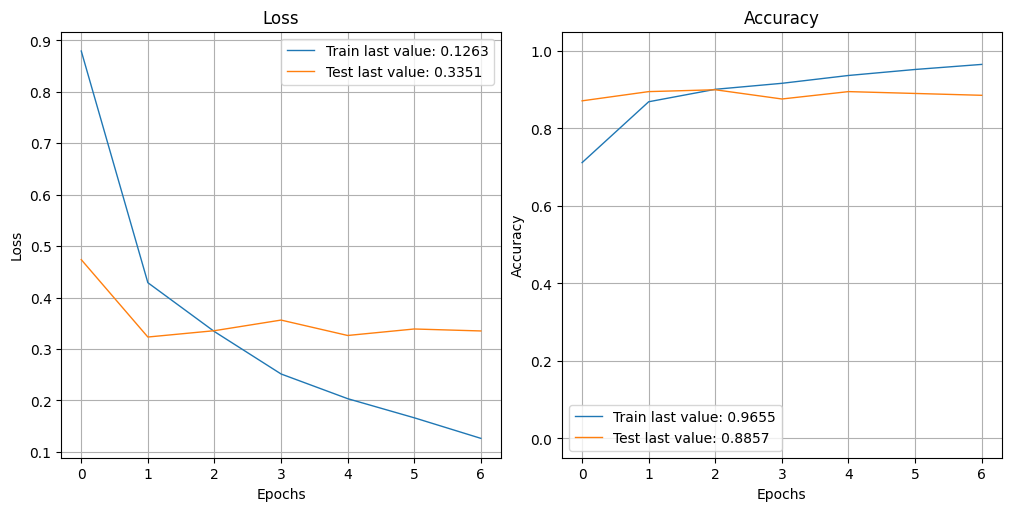

In [25]:
show_history(history1)
plot_history(history1, path ="M1.png")
plt.close()

7/7 [==============================] - 11s 1s/step
Correspondance des clusters :  [0 1 2 3 4 5 6]
[[21  1  0  3  4  1  0]
 [ 0 28  0  1  1  0  0]
 [ 0  1 28  1  0  0  0]
 [ 0  0  0 28  1  1  0]
 [ 2  0  0  1 27  0  0]
 [ 0  1  2  2  0 25  0]
 [ 0  0  0  0  0  1 29]]

              precision    recall  f1-score   support

           0       0.91      0.70      0.79        30
           1       0.90      0.93      0.92        30
           2       0.93      0.93      0.93        30
           3       0.78      0.93      0.85        30
           4       0.82      0.90      0.86        30
           5       0.89      0.83      0.86        30
           6       1.00      0.97      0.98        30

    accuracy                           0.89       210
   macro avg       0.89      0.89      0.88       210
weighted avg       0.89      0.89      0.88       210



<Axes: >

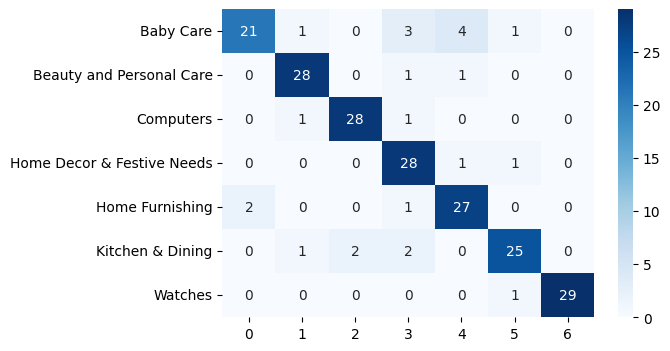

In [26]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)

conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)

y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Approche 2 : ImageDatagenerator et data augmentation

In [27]:
# Mélange des images (initialement classées par catégories dans le dataset fourni)
data = df.sample(frac=1, random_state=rs).reset_index(drop=True)

In [28]:
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(df_test, datagen_test, data_type=None)

Found 788 validated image filenames belonging to 7 classes.
Found 262 validated image filenames belonging to 7 classes.
Found 1050 validated image filenames belonging to 7 classes.


In [29]:
# Création du modèle
model2 = create_model_fct()

# Création du callback
model2_save_path = "./Model/modelXcep2_datagenerator.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_31 (Add)                   (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_30[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_31[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_34 (A

In [30]:
# Entrainement du modèle
start_m2 = time.time()
history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=bs, epochs=50, callbacks=callbacks_list, verbose=1)
end_m2 = time.time()
time_m2 = round(end_m2 - start_m2, 2)

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.1656 - accuracy: 0.6206

C:\Users\JayCo\anaconda3\envs\EnvP6\lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.53977, saving model to ./Model\modelXcep2_datagenerator.h5
25/25 [==============================] - 43s 2s/step - loss: 1.1656 - accuracy: 0.6206 - val_loss: 0.5398 - val_accuracy: 0.8473
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.6242 - accuracy: 0.7957
Epoch 2: val_loss improved from 0.53977 to 0.52373, saving model to ./Model\modelXcep2_datagenerator.h5
25/25 [==============================] - 41s 2s/step - loss: 0.6242 - accuracy: 0.7957 - val_loss: 0.5237 - val_accuracy: 0.8282
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.4716 - accuracy: 0.8553
Epoch 3: val_loss improved from 0.52373 to 0.47014, saving model to ./Model\modelXcep2_datagenerator.h5
25/25 [==============================] - 41s 2s/step - loss: 0.4716 - accuracy: 0.8553 - val_loss: 0.4701 - val_accuracy: 0.8473
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.4668 - accuracy: 0.8477
Epoch 4: val_loss impr

In [31]:
# Temps d'entrainement
print("Temps de training : {}s".format(time_m2))
print('--------')

# Évaluation du modèle sur l'ensemble d'entrainement
train_loss_m2, train_acc_m2 = model2.evaluate(train_flow)
print('Train accuracy :', round(train_acc_m2, 4))
print('Train loss :', round(train_loss_m2, 4))
print('--------')

# Évaluation du modèle sur l'ensemble de validation
val_loss_m2, val_acc_m2 = model2.evaluate(val_flow)
print('Validation accuracy :', round(val_acc_m2, 4))
print('Validation loss :', round(val_loss_m2, 4))
print('--------')

# Évaluation du modèle sur l'ensemble de test
test_loss_m2, test_acc_m2 = model2.evaluate(test_flow)
print('Test accuracy :', round(test_acc_m2, 4))
print('Test loss :', round(test_loss_m2, 4))

Temps de training : 369.11s
--------
25/25 [==============================] - 30s 1s/step - loss: 0.1726 - accuracy: 0.9404
Train accuracy : 0.9404
Train loss : 0.1726
--------
9/9 [==============================] - 10s 1s/step - loss: 0.5300 - accuracy: 0.8397
Validation accuracy : 0.8397
Validation loss : 0.53
--------
33/33 [==============================] - 38s 1s/step - loss: 0.2141 - accuracy: 0.9333
Test accuracy : 0.9333
Test loss : 0.2141


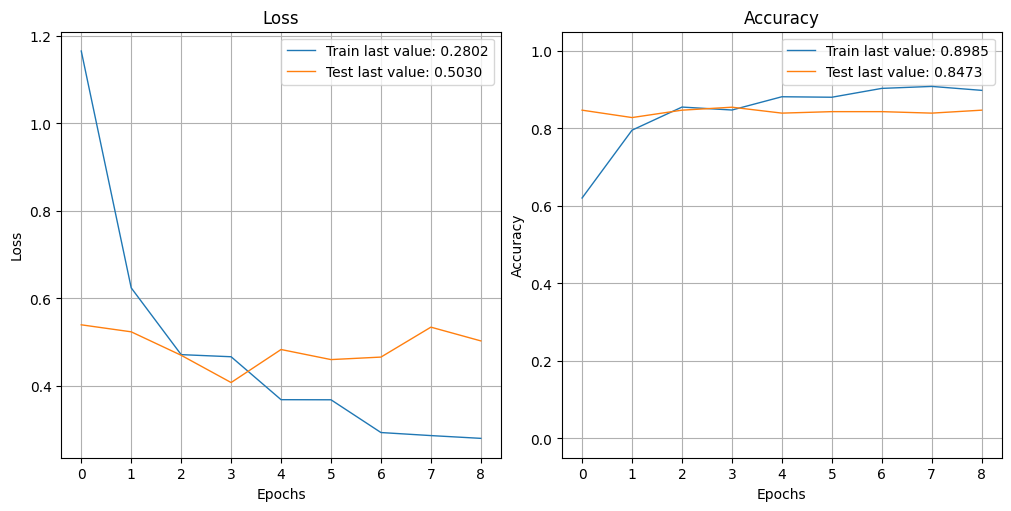

In [32]:
show_history(history2)
plot_history(history2, path ="M2.png")
plt.close()

## Approche 3 : Image_dataset_from_directory (data augmentation intégrée)

In [45]:
# Chemin du nouveau dossier créé contenant toutes les images
path_img2 = './Img/'

# Classer les images selon leur catégorie réelle
for index, row in df.iterrows():
    # Chemin complet de l'image
    chemin_image = os.path.join(path_img2, row['image'])

    # Vérifier si le fichier existe
    if os.path.isfile(chemin_image):
        # Chemin vers le dossier de destination pour la catégorie
        chemin_categorie = os.path.join(path_img2, row['main_cat'])

        # Créer le dossier de destination pour la catégorie s'il n'existe pas déjà
        if not os.path.exists(chemin_categorie):
            os.makedirs(chemin_categorie)

        # Déplacer l'image vers le dossier de destination de la catégorie
        shutil.move(chemin_image, chemin_categorie)

In [46]:
# Split du dataset (train/val/test)
def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=bs, image_size=(299, 299), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset


dataset_train = dataset_fct(path_img2, validation_split=0.2, data_type='training')
dataset_val = dataset_fct(path_img2, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_img2, validation_split=0, data_type=None)

Found 1050 files belonging to 7 classes.
Using 840 files for training.
Found 1050 files belonging to 7 classes.
Using 262 files for validation.
Found 1050 files belonging to 7 classes.


In [47]:
#Création du modèle avec augmentation de données
model3 = create_model_fct2()

# Création du callback
model3_save_path = "./Model/modelXcep3_dataset_from_directory.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

# Entraîner le modèle avec le dataset augmenté
start_m3 = time.time()
history3 = model3.fit(dataset_train, epochs=50, validation_data=dataset_val, batch_size=bs, callbacks=callbacks_list)
end_m3 = time.time()
time_m3 = round(end_m3 - start_m3, 2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 21,387,823
Trainable params: 526,343
Non

In [48]:
# Temps d'entrainement
print("Temps de training : {}s".format(time_m3))
print('--------')

# Évaluation du modèle sur l'ensemble d'entrainement
train_loss_m3, train_acc_m3 = model3.evaluate(dataset_train)
print('Train accuracy :', round(train_acc_m3, 4))
print('Train loss :', round(train_loss_m3, 4))
print('--------')

# Évaluation du modèle sur l'ensemble de validation
val_loss_m3, val_acc_m3 = model3.evaluate(dataset_val)
print('Validation accuracy :', round(val_acc_m3, 4))
print('Validation loss :', round(val_loss_m3, 4))
print('--------')

# Évaluation du modèle sur l'ensemble de test
test_loss_m3, test_acc_m3 = model3.evaluate(dataset_test)
print('Test accuracy :', round(test_acc_m3, 4))
print('Test loss :', round(test_loss_m3, 4))

Temps de training : 968.29s
--------
27/27 [==============================] - 44s 2s/step - loss: 0.0620 - accuracy: 0.9857
Train accuracy : 0.9857
Train loss : 0.062
--------
9/9 [==============================] - 14s 1s/step - loss: 0.2883 - accuracy: 0.9046
Validation accuracy : 0.9046
Validation loss : 0.2883
--------
33/33 [==============================] - 55s 2s/step - loss: 0.1185 - accuracy: 0.9657
Test accuracy : 0.9657
Test loss : 0.1185


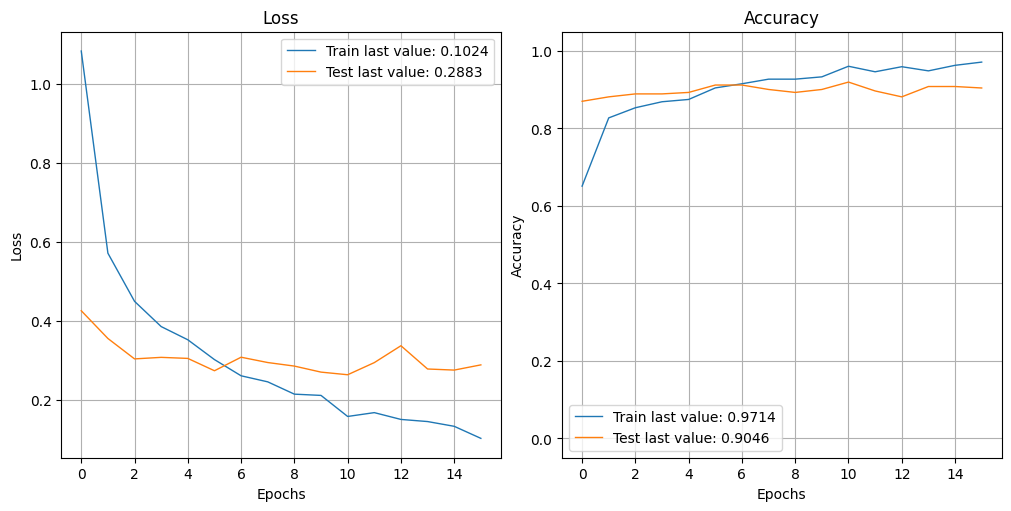

In [49]:
show_history(history3)
plot_history(history3, path ="M3.png")
plt.close()

## Comparaison des différentes approches (modèle utilisé : Xception)

In [122]:
# Tableau des résultats de modélisation
results_df = pd.DataFrame({
    'Method' :['Prép initiale des images (sans data augmentation)', 
               'ImageDataGenerator + Data augmentation', 
               'Image_dataset_from_directory + Data augmentation'],
    'Training time (s)' : [time_m1, time_m2, time_m3],
    'Train acc' : [train_acc_m1, train_acc_m2, train_acc_m3],
    'Train loss' : [train_loss_m1, train_loss_m2, train_loss_m3],
    'Val. acc' : [val_acc_m1, val_acc_m2, val_acc_m3],
    'Val. loss' : [val_loss_m1, val_loss_m2, val_loss_m3],
    'Test acc' : [test_acc_m1, test_acc_m2, test_acc_m3],
    'Test loss' : [test_loss_m1, test_loss_m2, test_loss_m3]
})

print('Modèle retenu : Xception')
print('Encoder : LabelEncoder')
print('Batch_size : {}'.format(bs))
print('Epochs : 50 (with early stopping)')
print('Random_state : {}'.format(rs))
print('______________________')

display(results_df)

Modèle retenu : Xception
Encoder : LabelEncoder
Batch_size : 32
Epochs : 50 (with early stopping)
Random_state : 42
______________________


,Method,Training time,Train acc,Train loss,Val. acc,Val. loss,Test acc,Test loss
0,Prép initiale des images (sans data augmentation),526.51,0.992857,0.028407,0.885714,0.400726,0.971429,0.102871
1,ImageDataGenerator + Data augmentation,371.80,0.956853,0.139504,0.851145,0.499971,0.940000,0.186125
2,Image_dataset_from_directory + Data augmentation,995.23,0.977381,0.071859,0.904580,0.305940,0.958095,0.131765


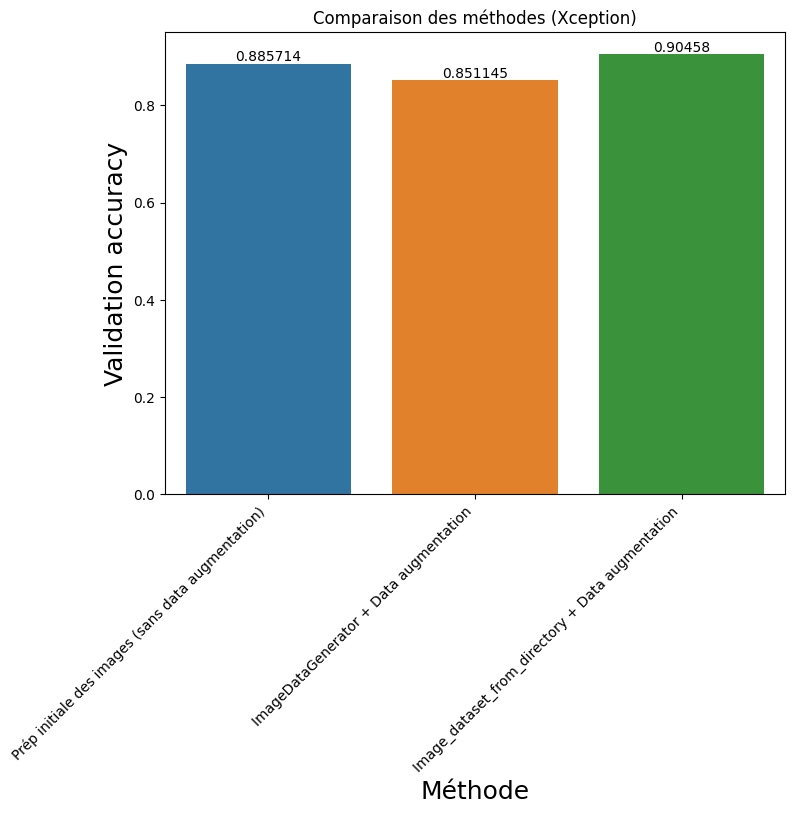

In [123]:
# Représentation graphique
plt.figure(figsize=(8, 6))

ax = sns.barplot(data=results_df, x="Method", y="Val. acc")
for i in ax.containers:
    ax.bar_label(i,)
plt.xticks(rotation=45, ha='right')
plt.title('Comparaison des méthodes (Xception)')
plt.xlabel('Méthode', fontsize=18)
plt.ylabel('Validation accuracy', fontsize=18)

plt.show()

#### CONCLUSION :  
  
Sur les trois approches que nous avons testé (RandomForest exclu), Image_dataset_from_directory (avec data augmentation) semble obtenir les meilleurs résultats selon les critères de Validation et de Test Accuracy. Les résultats sont satisfaisants et permettent de considérer comme pertinente la classification automatique des produits de la market place.